# TensorFlow - CNN - MNIST

---

## 目標
* 了解`卷積神經網路 (CNN)`基本架構
* 撰寫`CNN`常用的層

## 索引
### [1 載入資料](#1.-載入資料)
### [2 卷積神經網路 CNN](#2.-卷積神經網路-CNN)
[2.1 卷積層 Convolution](#2.1-卷積層-Convolution)  
[2.2 池化層 MaxPooling](#2.2-池化層-MaxPooling)  
[2.3 推測](#2.3-推測)  
[2.4 建立模型](#2.4-建立模型)  

### [3 權重輸出](#3.-權重輸出)
[3.1 模型讀取](#3.1-模型讀取)  
[3.2 取各層節點輸出](#3.2-取各層節點輸出)  
[3.3 各類別的索引](#3.3-各類別的索引)  
[3.4 畫出輸出](#3.4-畫出輸出)  

### [4 總結](#4.-總結)

## 1. 載入資料

In [1]:
from my_model import layer, loss, training_no_optimizer, evaluate
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import input_data

mnist = input_data.read_data_sets('datasets/mnist', one_hot=True)

Extracting datasets/mnist\train-images-idx3-ubyte.gz
Extracting datasets/mnist\train-labels-idx1-ubyte.gz
Extracting datasets/mnist\t10k-images-idx3-ubyte.gz
Extracting datasets/mnist\t10k-labels-idx1-ubyte.gz


## 2. 卷積神經網路 CNN

<img style='float:right;' width='35%' src="https://www.researchgate.net/profile/Jaime_Gallego2/publication/318168077/figure/fig1/AS:578190894927872@1514862859810/AlexNet-CNN-architecture-layers.png">
在機器視覺得這個領域, 一直到卷積網路出現以前都是一個非常困難的問題.  
在過去, 通常都是由人工設計特徵, 在交給電腦去進行學習, 有時候特徵可能高達好幾百或好幾千個.  
假設一開始人工挑選特徵是適當的, 那麼確實能夠取得不錯的成果, 但是耗日費時.  
直到 2012 年, 由多倫多大學實驗室開創了`CNN`的深度學習架構, 在當年的比賽中刷新了比賽的紀錄.  
這一套真正把深度學習帶進電腦視覺的領域的網路架構, 叫做`AlexNet`, 有興趣可以去查查文件.  


### 2.1 卷積層 Convolution

<img style='float:left;' width='20%'  src="https://cdn-images-1.medium.com/max/1600/1*ZCjPUFrB6eHPRi4eyP6aaA.gif" >
卷積層的運作原理是模仿大腦對視覺的觸發, 人腦在看到東西時, 有的神經元只有在看到垂直線條時被觸發, 而有的只有在看到水平線被觸發.  
而視覺皮層是分層的結構, 每一層都根據前一層所偵測到的特徵進一步分析特徵, 直到整個物體.  
而這個就是卷積層的概念, 也就是`特徵偵測器 (feature detector)`, 圖中是一個卷積神經元的運作.  
我們通常直接把這個操作叫做`過濾器`, `過濾器`會用數值的方式計算圖中哪邊有特徵出現, 然後傳給下一層.  
透過多層次的卷積操作, 網路會得到大量的全新的特徵, 利用這些特徵來進行最後的分類, 這就是當初卷積神經網路的設計架構.  

首先, 接收的輸入具有以下的特徵:
1. `寬度 w` 輸入的圖片寬度
2. `高度 h` 輸入的圖片高度
3. `深度 d` 又稱作通道數, 一般彩圖的通道數是3, 黑白圖片是1
4. `空白填充值 p` 由卷積層自動補上, 這是為了讓圖片的寬度高度不要因為卷積操作而改變  

一個卷積層中, 我們會設定幾個超參數如下:
1. `空間範圍 spatial extent` 過濾器的寬度和高度
2. `步輻 stride` 每次過濾器移動的距離  




In [3]:
def conv2d(inputs, weight_shape, bias_shape):
    ''' 定義卷積層, 固定strides=1, padding='SAME' '''
    
    # kernel的形狀
    size = weight_shape[0] * weight_shape[1] * weight_shape[2]
    
    # 初始化權重跟神經元
    weight_init = tf.random_normal_initializer(stddev=(2.0/size)**0.5)
    bias_init = tf.constant_initializer(value=0)
    w = tf.get_variable('w', weight_shape, initializer=weight_init)
    b = tf.get_variable('b', bias_shape, initializer=bias_init)
    
    # 卷積計算, 注意要做一個 2D_CONV 運算, inputs, filter 需要輸入 4D
    # inputs : [num_of_examples, width, height, channel] -- 4D
    # strides : [filter_height, filter_width, in_channels, out_channels] -- 4D
    conv = tf.nn.conv2d(inputs, w, strides=[1, 1, 1, 1], padding='SAME')
    
    # 加上誤差項後用, relu 輸出
    relu = tf.nn.relu(tf.nn.bias_add(conv, b))
    
    return relu

### 2.2 池化層 MaxPooling

<img style='float:left' width='30%' src="https://dn-anything-about-doc.qbox.me/document-uid49570labid2914timestamp1494492666030.png">
圖中是一個池化的示意圖, 池化可以很有效的減少參數數量.  
還有一個特點就是`局部不變 locally invariant`的特性, 這讓我們即使輸入的資料有偏差, 還是可以保持輸出.  

In [4]:
def max_pool(inputs, k=2):
    ''' 定義最大池化層, 固定padding="SAME" '''
    
    # 設定池化參數, ksize是池化的空間範圍, strides是池化移動步伐
    pool = tf.nn.max_pool(inputs, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
    
    return pool

### 2.3 推測

由於我們有了全新的層, 透過這兩個層我們可以設計`AlexNet`的網路架構了.  
在標準的`CNN`設計架構的發展如下：
* inputs => conv => dense => softmax => output
* inputs => conv => pool => dense => soft => output
* inputs => 3x (conv, conv, pool) => 2x dense => softmax => output
* inputs => 2x (conv, conv, pool) => 3x (conv, conv, conv, pool) => dense => dense => softmax => output  

最下面這個就是後來很有名的`VGGNet`網路架構.

In [5]:
def inference(x, keep_prob):
    # 將資料轉換成 [num_of_examples, widths, heights, channels] 結構. 
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    
    # 進行兩次 卷積+池化 操作
    with tf.variable_scope('conv_1'):
        conv_1 = conv2d(x, [3, 3, 1, 16], [16])
        pool_1 = max_pool(conv_1) # shape=[-1, 14, 14, 32]
    with tf.variable_scope('conv_2'):
        conv_2 = conv2d(pool_1, [3, 3, 16, 64], [64])
        pool_2 = max_pool(conv_2) # shape=[-1, 7, 7, 64]
        
    # 將資料展開, 設定 drop out 防止 overfitting
    with tf.variable_scope('fc'):
        pool_2_flat = tf.reshape(pool_2, shape=[-1, 7 * 7 * 64])
        fc_1 = layer(pool_2_flat, [7*7*64, 1024], [1024])
        fc_1_drop = tf.nn.dropout(fc_1, keep_prob)
        
    # 將資料丟到全連結層輸出
    with tf.variable_scope('output'):
        output = layer(fc_1_drop, [1024, 10], [10])
        
    return np.array([conv_1, conv_2, output])

### 2.4 建立模型

In [6]:
def run_a_model(logdir='logs/cnn_model', epochs=50, batch_size=128):
    with tf.Graph().as_default() as g:
        with tf.variable_scope('model') as scope:
            global_step = tf.Variable(0, name='global_step', trainable=False)
            optimizer = tf.train.AdamOptimizer()

            x = tf.placeholder('float', [None, 784], name='x')
            y = tf.placeholder('float', [None, 10], name='y')

            output = inference(x, 0.5)[-1]
            cost = loss(output, y)
            train = training_no_optimizer(cost, optimizer, global_step)
            eva = evaluate(output, y)

            summary = tf.summary.merge_all()
            saver = tf.train.Saver(max_to_keep=1)
            summary_writer = tf.summary.FileWriter(logdir, graph=g)

            init = tf.global_variables_initializer()
            sess = tf.Session()
            sess.run(init)

            for epoch in range(epochs):
                total_batch = mnist.train.num_examples//batch_size

                for i in range(total_batch):
                    batch_x, batch_y = mnist.train.next_batch(batch_size)
                    sess.run(train, feed_dict={x:batch_x, y:batch_y})

                if (epoch+1) % 10 == 0 or epoch == 0:
                    train_acc = sess.run(eva, feed_dict={x:mnist.train.images[::10], y:mnist.train.labels[::10]})
                    val_acc = sess.run(eva, feed_dict={x:mnist.validation.images, y:mnist.validation.labels})
                    print('Epochs:', '%04d'%(epoch+1), 'train_error:', '{:.6f}'.format(1-train_acc), 'val_error:', '{:.6f}'.format(1-val_acc))

                summary_str = sess.run(summary, feed_dict={x:batch_x, y:batch_y})
                summary_writer.add_summary(summary_str, sess.run(global_step))
                saver.save(sess, logdir+'/model-checkpoint', global_step=global_step)

            print('Optimization Finished!')

            result = sess.run(eva, feed_dict={x:mnist.test.images, y:mnist.test.labels})        
            print('Test accuracy', result)

In [7]:
run_a_model()

Epochs: 0001 train_error: 0.227636 val_error: 0.214600
Epochs: 0010 train_error: 0.004182 val_error: 0.011600
Epochs: 0020 train_error: 0.001091 val_error: 0.007800
Epochs: 0030 train_error: 0.000909 val_error: 0.011600
Epochs: 0040 train_error: 0.000727 val_error: 0.012200
Epochs: 0050 train_error: 0.000727 val_error: 0.009000
Optimization Finished!
Test accuracy 0.989


## 3. 權重輸出

其實理論上的了解一個模型運作, 跟我們真的解剖看到裡面的運作.  
這兩者之間真的還是泥雲之別吧, 這邊我們試著把模型各層的輸出都取出來看看.  

#### 3.1 模型讀取

In [8]:
sess = tf.Session()
saver = tf.train.import_meta_graph('logs/cnn_model/model-checkpoint-21450.meta')
saver.restore(sess, tf.train.latest_checkpoint('logs/cnn_model'))

INFO:tensorflow:Restoring parameters from logs/cnn_model\model-checkpoint-21450


In [9]:
g = tf.get_default_graph()

x = g.get_tensor_by_name('model/x:0')
y = g.get_tensor_by_name('model/y:0')

In [10]:
feed_dict={x:mnist.test.images, y:mnist.test.labels}

上方是我們讀取模型的起手式, 千萬不要忘記啦!  
後面我們可能會使用只讀取某部分權重的方式`部分載入模型`.  
但是現在模型還很小, 就算全部讀出來也不耗費時空間, 無妨.  

#### 3.2 取各層節點輸出

In [11]:
# 先定義我們需要拿出的各節點名稱
actions = ['model/conv_1/Relu:0',
               'model/conv_1/MaxPool:0',
               'model/conv_2/Relu:0',
               'model/conv_2/MaxPool:0']

# 將各節點取出
actions = [g.get_tensor_by_name(act) for act in actions]

# 再用測試資料拿到各節點輸出
actions_output = [sess.run(act, feed_dict) for act in actions]

我們可以看一下各節點的輸出, 可以推測一下設計的結構.  
首先是只要遇到`conv`層, 通道數會增加, 這是為了能夠用`過濾器`取出更多特徵.  
接著是遇到`max pool`層, 圖片會變小, 當然這很明顯是為了降低參數數量.  

In [12]:
for idx, act in enumerate(actions_output):
    print(act.shape, actions[idx].name)

(10000, 28, 28, 16) model/conv_1/Relu:0
(10000, 14, 14, 16) model/conv_1/MaxPool:0
(10000, 14, 14, 64) model/conv_2/Relu:0
(10000, 7, 7, 64) model/conv_2/MaxPool:0


#### 3.3 各類別的索引

由於我們想知道各個類別丟進模型後, 到底經過了什麼化學反應.  
所以我們要對類別做文章了, 試著將各個類別分開來.  

In [13]:
# one hot 格式, 放進 dataframe裡面準備處理
labels = pd.DataFrame(mnist.test.labels)

# 由於我們知道各 col名稱都是數字 0~9 因此直接乘上去, 就會拿到對應每一格  ex.[0, 0, 0, 0, 0, 0, 0, 0, 9]
labels = labels.apply(lambda col: col*col.name)

# 這時候我們就可以用 max(axis=1), 這會讓每一個 row 都取最大值, 到此我們就把 one hot 轉成一般的陣列了
labels = labels.max(axis=1)

# 這邊我們捨棄了groupby的方式, 直接下判斷式, 就可以把對應各個類別的 index 放進各個類別中
labels_separate_idx = [labels[labels==i].index for i in range(10)]

In [14]:
# 稍微檢查一下有沒有錯, 要確定有 0~9 的分類
# 由於我們看過資料集, 也可以看一下剛剛的操作是不是有平衡的分出來, 沒有的話一定是哪裡打錯了
for idx, label in enumerate(labels_separate_idx):
    print(idx, label.size, end=", ")

0 980, 1 1135, 2 1032, 3 1010, 4 982, 5 892, 6 958, 7 1028, 8 974, 9 1009, 

#### 3.4 畫出輸出

最重要的工作反而是最簡單的?  
我們做了這麼多瑣碎的小事, 其實最終目的就只有一個:  
那就是我們希望看到**`卷積神經網路到底在幹什麼`**.  
首先, 我們先回憶一下剛剛的模型.  
1. 資料輸入後, 經過一層`conv`來抽取特徵
2. 由於資料變多了, 我們丟進`max pool`減少參數
3. 接著我們又用`conv`抽取特徵
4. 再次的, 使用`max pool`減少參數  

於是我們把原始資料跟這四層輸出畫在下面.  

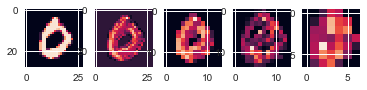

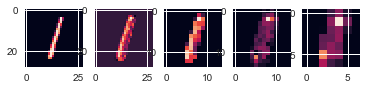

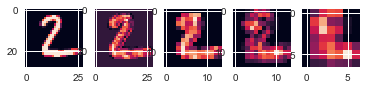

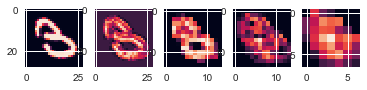

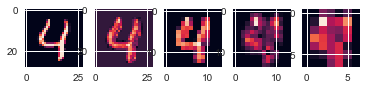

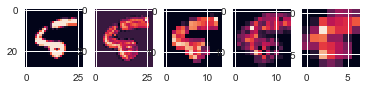

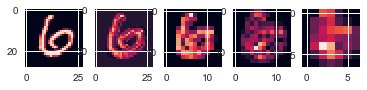

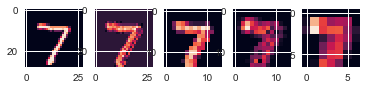

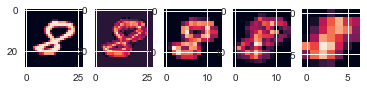

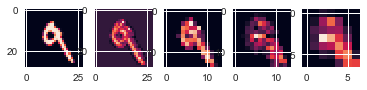

In [15]:
# 我們每個類別都想看, 對吧?
for num in range(10):
    # 取每個類別第一張圖
    idx = labels_separate_idx[num][0]
    
    # 設定讓 python 橫著畫
    fig, axes = plt.subplots(1, 5)

    # 畫圖
    axes[0].imshow(mnist.test.images[idx].reshape((28,28)))
    axes[1].imshow(actions_output[0][idx].max(axis=2))
    axes[2].imshow(actions_output[1][idx].max(axis=2))
    axes[3].imshow(actions_output[2][idx].max(axis=2))
    axes[4].imshow(actions_output[3][idx].max(axis=2))
    plt.show()

這樣我們就看到啦~~  
其實說白話一點, `conv`就是幫我們描邊, 讓資料特徵明顯一點.  
接著`max pool`就很明顯啦, 就是把資料收斂, 強迫用更少的資料量表達資料.  


## 4. 總結
  
在這邊, 恭喜我們從手寫數字集畢業了~~  
如果有從一開始練習到這邊的小夥伴, 應該已經順利的獲得了**`用深度網路處理簡單資料的能力`**.  
接下來的內容就要使用其他的數據集了, 畢竟再怎麼樣我們都不可能把手寫數字的準確提升到120%嘛!  